# Google Notebook specific Stuff

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install pytorch-lightning==1.3.3
# !pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl
!pip install scGeneFit
!pip install scanpy
!pip install anndata
!pip install lassonet
# my version of smashpy that fixed imports, nothing else was changed
!pip install matplotlib>=3.3.2
!pip install shap>=0.37.0
!pip install xgboost>=1.3.3
!pip install imbalanced-learn>=0.7.0
!pip install numba>=0.51.2
!pip install harmonypy>=0.0.5
!git clone https://github.com/beelze-b/SmashFork.git
!git clone https://github.com/ahsv/RankCorr.git

     |████████████████████████████████| 806 kB 5.3 MB/s 
     |████████████████████████████████| 119 kB 49.7 MB/s 
     |████████████████████████████████| 636 kB 38.4 MB/s 
     |████████████████████████████████| 829 kB 42.3 MB/s 
     |████████████████████████████████| 282 kB 43.2 MB/s 
     |████████████████████████████████| 1.3 MB 34.2 MB/s 
     |████████████████████████████████| 142 kB 48.0 MB/s 
     |████████████████████████████████| 294 kB 31.5 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=f531e5e6cbeea4b676dd994dc752072eef649e511e9dc5c228b81d6708be706b
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [3]:
# Check GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep 15 02:42:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import sys
import os
# to import utils
sys.path.append(os.path.abspath('/content/gdrive/My Drive/Differentiable-Sparse-Subset-Selection/notebooks'))

# All the Imports

In [5]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lassonet import LassoNetClassifier


from RankCorr.picturedRocks import Rocks
import SmashFork.smashpy as smashpy
import anndata


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part o

CPU times: user 20.6 s, sys: 1.18 s, total: 21.8 s
Wall time: 27.2 s


# These should be parameters later on 

In [6]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 5

gpus = 1
tpu_cores = None

In [7]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

# Here goes all the stuff that we change from dataset to dataset

In [8]:
from os import path

In [9]:
dataset_dir = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/synthetic/'
model_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/synthetic/models/'
viz_save_path = '/content/gdrive/MyDrive/Differentiable-Sparse-Subset-Selection/data/synthetic/visualizations/'

if not path.exists(model_save_path):
  os.mkdir(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.mkdir(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.mkdir(viz_save_path)

  

# Dataset Specific Processing

`

In [10]:
X, y = generate_synthetic_data_with_noise(N=10000, z_size=z_size, n_classes=5, D = hidden_layer_size * 2, seed = 1234)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.astype('int')
labels = pd.Series([chr(97+i) for i in y], dtype='category')
encoder = LabelEncoder()
# remains the same but just to make sure
y = encoder.fit_transform(y)
adata = anndata.AnnData(X = X, obs = labels.values)
adata.obs['annotation'] = labels.values

In [11]:
input_size = X.shape[1]
y

array([0, 0, 0, ..., 4, 4, 4])

# Set Up Models

## Train Smash Random Forest





In [ ]:
# needed for random forest Smash
!mkdir Figures

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

In [ ]:
results

## Train Smash DNN

the data is treated a bit differently than our other models

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(adata, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(adata, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [ ]:
results

## Train RankCorr

In [ ]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 11# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        print("Excess Length of markers")
        print(len(rankcorr_markers))
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

In [ ]:
len(rankcorr_markers)

In [ ]:
print("Some, if not all, selected gene names")
print(marker_genes)

In [ ]:
results

## Train L1 VAE

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = 16)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

In [ ]:
results

## Train Global Gate

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

In [ ]:
model.t

In [ ]:
results

## Train Running State VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = VAE_Gumbel_RunningState(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE Marker Visualization', path = viz_save_path + 'runningstate_vae_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.t

In [ ]:
results

In [ ]:
model.t

## Running State Classifier

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = GumbelClassifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    runningstate_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = runningstate_markers)
    np.save(model_save_path + 'runningstate_classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_classifier_markers_{}.npy'.format(tryy), runningstate_markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State Classifier Marker Visualization', path = viz_save_path + 'runningstate_classifier_markers_{}.png'.format(tryy), markers = runningstate_markers)

In [ ]:
model.lr

In [ ]:
model.t

In [ ]:
model.hparams.lr

In [ ]:
results

## RunningState VAE+Classifier

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification_decoder | Sequential | 6.1 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.151     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification

New Learning Rate 0.0006200038000000001


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



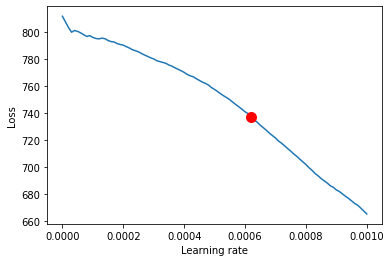

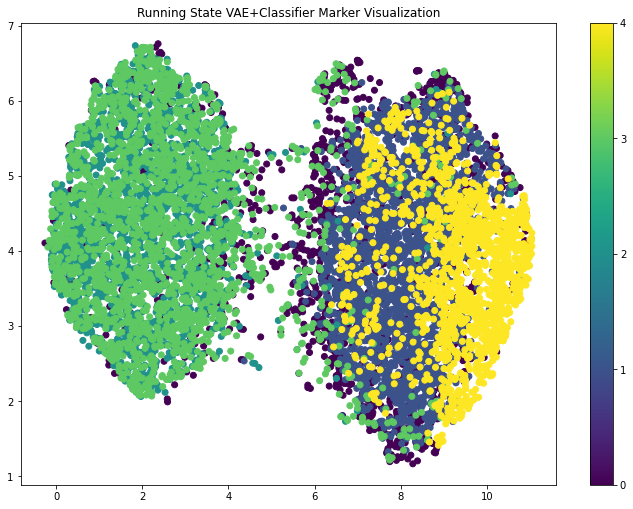

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification_decoder | Sequential | 6.1 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.151     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification

New Learning Rate 0.0009000010000000001


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



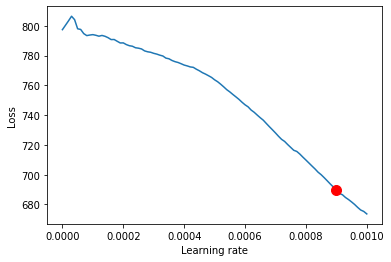

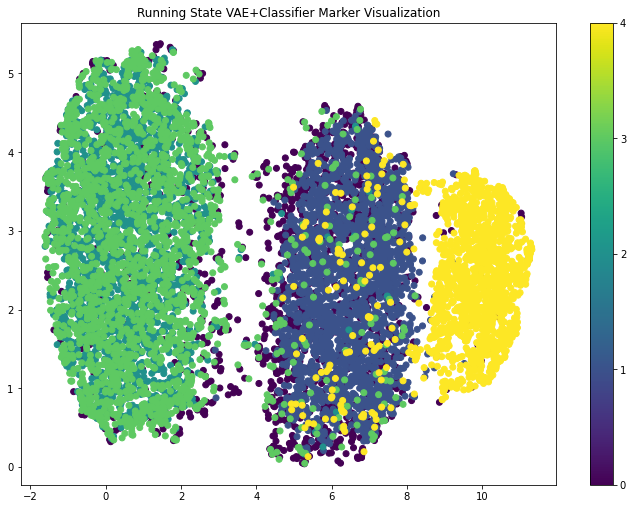

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification_decoder | Sequential | 6.1 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.151     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification

New Learning Rate 0.0009500005000000001


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



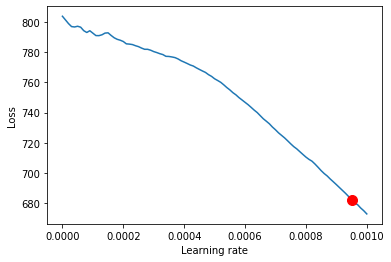

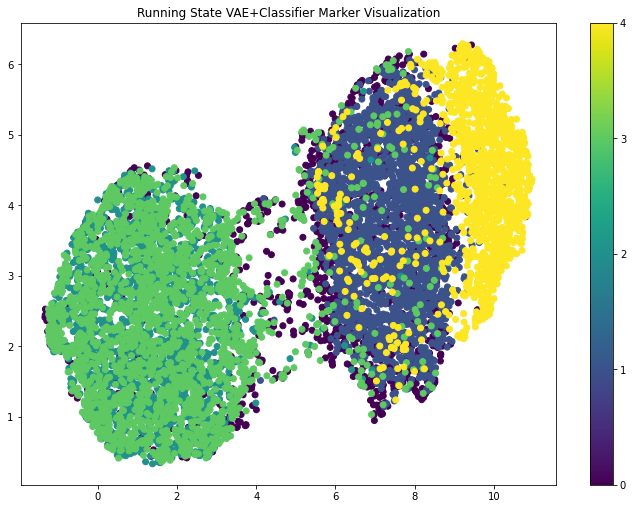

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification_decoder | Sequential | 6.1 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.151     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification

New Learning Rate 0.0009900001


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



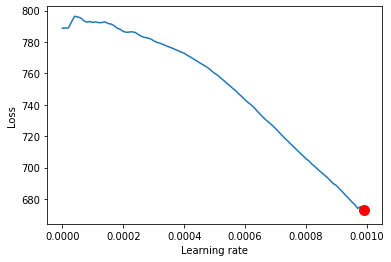

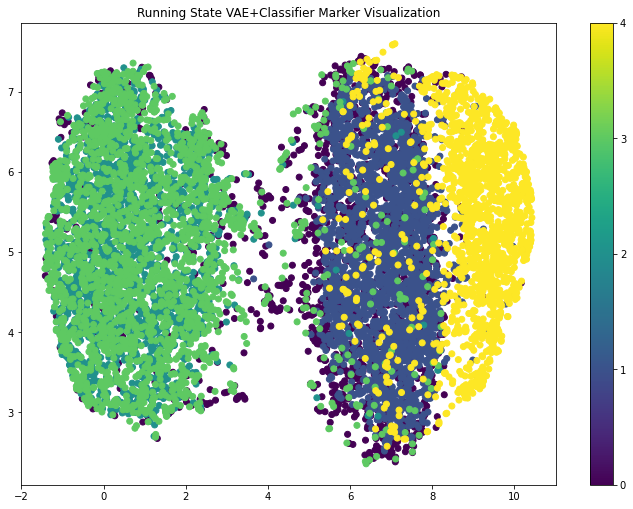

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification_decoder | Sequential | 6.1 K 
7 | classification_loss    | NLLLoss    | 0     
------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.151     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | encoder                | Sequential | 395 K 
1 | enc_mean               | Linear     | 4.1 K 
2 | enc_logvar             | Linear     | 4.1 K 
3 | decoder                | Sequential | 268 K 
4 | dec_logvar             | Sequential | 268 K 
5 | weight_creator         | Sequential | 592 K 
6 | classification

New Learning Rate 0.0009100009000000002


Validation sanity check: 0it [00:00, ?it/s]

Training: 99it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



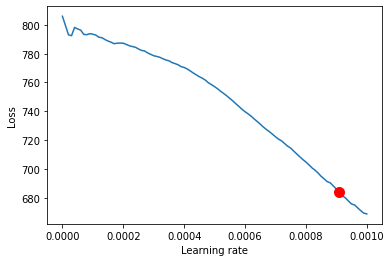

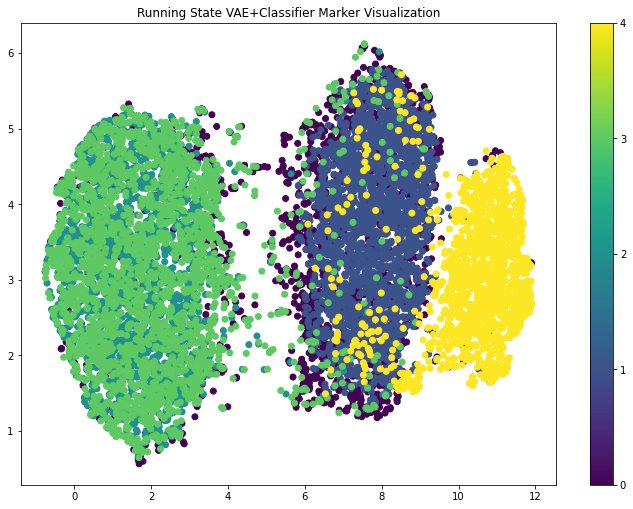

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = RunningState_VAE_Classifier(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = 16, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Running State VAE+Classifier Marker Visualization', path = viz_save_path + 'runningstate_vae+classifier_markers_{}.png'.format(tryy), markers = markers)

In [ ]:
results

(0.20139930034982512,
 {'0': {'f1-score': 0.8051529790660225,
   'precision': 0.8561643835616438,
   'recall': 0.7598784194528876,
   'support': 329},
  '1': {'f1-score': 0.9304932735426008,
   'precision': 0.9080962800875274,
   'recall': 0.9540229885057471,
   'support': 435},
  '2': {'f1-score': 0.6731470230862697,
   'precision': 0.6856435643564357,
   'recall': 0.6610978520286396,
   'support': 419},
  '3': {'f1-score': 0.6577042399172699,
   'precision': 0.6424242424242425,
   'recall': 0.673728813559322,
   'support': 472},
  '4': {'f1-score': 0.9670958512160229,
   'precision': 0.9575070821529745,
   'recall': 0.976878612716763,
   'support': 346},
  'accuracy': 0.7986006996501749,
  'macro avg': {'f1-score': 0.8067186733656371,
   'precision': 0.8099671105165648,
   'recall': 0.8051213372526718,
   'support': 2001},
  'weighted avg': {'f1-score': 0.7979810457464244,
   'precision': 0.7988537283080327,
   'recall': 0.7986006996501749,
   'support': 2001}},
 array([[250,  36,   

## Concrete VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = 16)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

In [ ]:
results = np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
results

## LassoNet

In [12]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



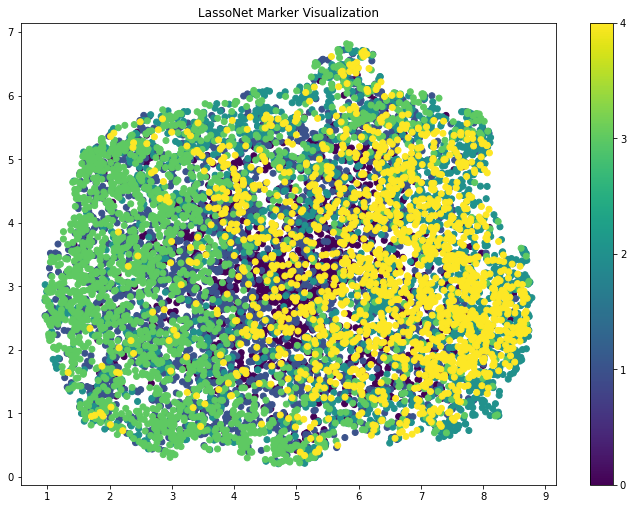

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



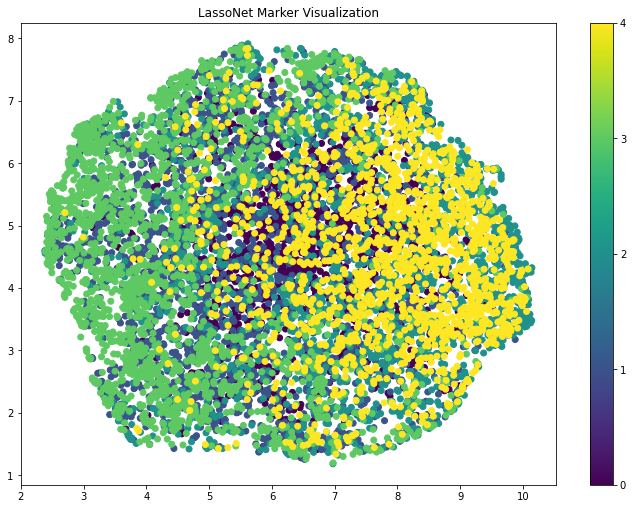

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



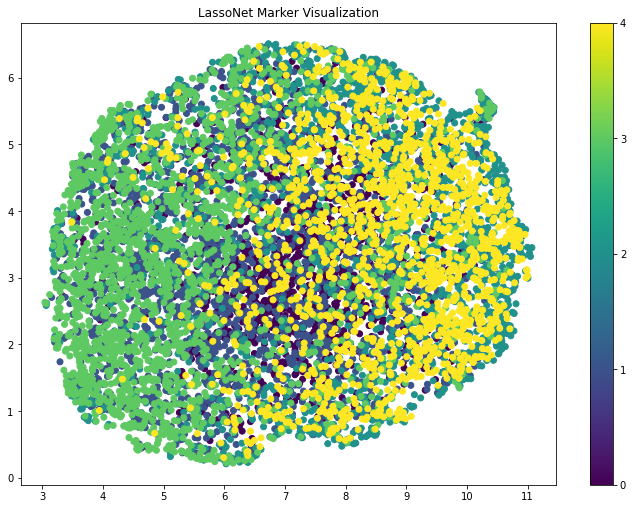

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



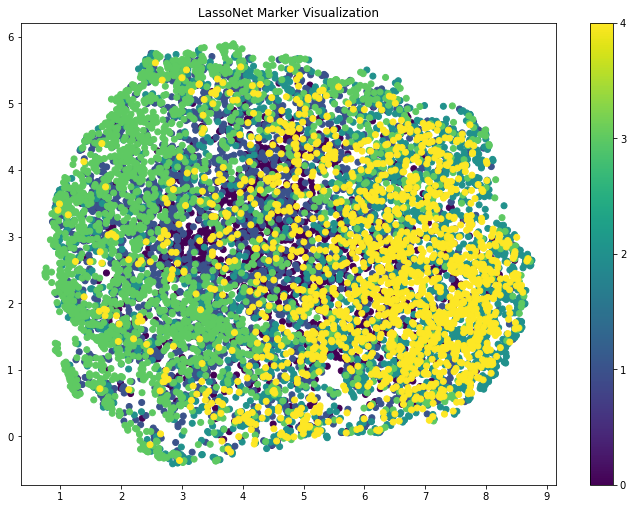

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



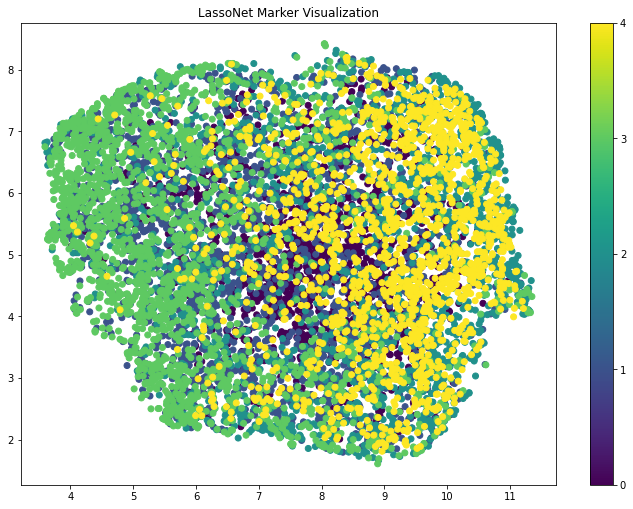

In [13]:
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier(hidden_dims = (hidden_layer_size, hidden_layer_size, hidden_layer_size))
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

In [14]:
results

(0.35382308845577215,
 {'0': {'f1-score': 0.6973886328725039,
   'precision': 0.739413680781759,
   'recall': 0.6598837209302325,
   'support': 344},
  '1': {'f1-score': 0.5685685685685685,
   'precision': 0.5557729941291585,
   'recall': 0.5819672131147541,
   'support': 488},
  '2': {'f1-score': 0.660996354799514,
   'precision': 0.6522781774580336,
   'recall': 0.6699507389162561,
   'support': 406},
  '3': {'f1-score': 0.7050847457627117,
   'precision': 0.6964285714285714,
   'recall': 0.7139588100686499,
   'support': 437},
  '4': {'f1-score': 0.6149068322981367,
   'precision': 0.6226415094339622,
   'recall': 0.6073619631901841,
   'support': 326},
  'accuracy': 0.6461769115442278,
  'macro avg': {'f1-score': 0.649389026860287,
   'precision': 0.653306986646297,
   'recall': 0.6466244892440154,
   'support': 2001},
  'weighted avg': {'f1-score': 0.6468312505975526,
   'precision': 0.6485361744935899,
   'recall': 0.6461769115442278,
   'support': 2001}},
 array([[227,  63,   1,

## Get Model Metrics from KNNs Classifiers


In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae_indices_{}.npy',
                                  model_save_path+'runningstate_vae_markers_{}.npy',
                                  model_save_path+'runningstate_vae_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_classifier_indices_{}.npy',
                                  model_save_path+'runningstate_classifier_markers_{}.npy',
                                  model_save_path+'runningstate_classifier_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [ ]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_markers_{}.npy',
                                  model_save_path+'runningstate_vae+classifier_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

In [17]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

# Results and Visualizations

## Accuracies and F1

In [18]:
result_axis = [
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('RunningGumbel VAE', 'runningstate_vae_results_{}.npy', 'runningstate_vae_knn_results_{}.npy'),
 ('RunningGumbel Classifier', 'runningstate_classifier_results_{}.npy', 'runningstate_classifier_knn_results_{}.npy'),
 ('RunningGumbel VAE+Classifier', 'runningstate_vae+classifier_results_{}.npy', 'runningstate_vae+classifier_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [19]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [20]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  ...  Weighted F1 Standard Deviation
L1 VAE                                      0.142629  ...                        0.006195
Smash RF                                    0.143828  ...                        0.005722
SMaSH DNN                                   0.139430  ...                        0.004441
RankCorr                                    0.137831  ...                        0.009045
Global Gate VAE                             0.174213  ...                        0.010071
RunningGumbel VAE                           0.150825  ...                        0.009038
RunningGumbel Classifier                    0.130435  ...                        0.003631
RunningGumbel VAE+Classifier                0.208296  ...                        0.012065
Concrete VAE                                0.179810  ...                        0.015566
LassoNet                                    0.360420  ...                        0.008646

[10 rows x 4 columns]

In [21]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [22]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  ...  Weighted F1 Standard Deviation
L1 VAE                                      0.252874  ...                        0.014599
Smash RF                                    0.200300  ...                        0.001217
SMaSH DNN                                   0.220790  ...                        0.013023
RankCorr                                    0.223488  ...                        0.010929
Global Gate VAE                             0.350525  ...                        0.022426
RunningGumbel VAE                           0.249975  ...                        0.018956
RunningGumbel Classifier                    0.201699  ...                        0.010205
RunningGumbel VAE+Classifier                0.323838  ...                        0.015464
Concrete VAE                                0.355122  ...                        0.046499
LassoNet                                    0.527636  ...                        0.007554

[10 rows x 4 columns]

## Confusion Matrices

k = 50

### Smash RF

In [ ]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

In [ ]:
results

In [ ]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.png', cmap = 'icefire')

### Smash DNN

In [ ]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.png', cmap = 'icefire')

### RankCorr

In [ ]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.png', cmap = 'icefire')

### L1 VAE

In [ ]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.png', cmap = 'icefire')

### Global Gate VAE

In [ ]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.png', cmap = 'icefire')

### Running Gumbel VAE

In [ ]:
results =  np.load(model_save_path + 'runningstate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel VAE Confusion Matrix', save_path = viz_save_path + 'runningstate_vae_cm.png', cmap = 'icefire')

### Running Gumbel Classifier


In [ ]:
results =  np.load(model_save_path + 'runningstate_classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_classifier_cm.png', cmap = 'icefire')

### RunningState VAE+Classifier

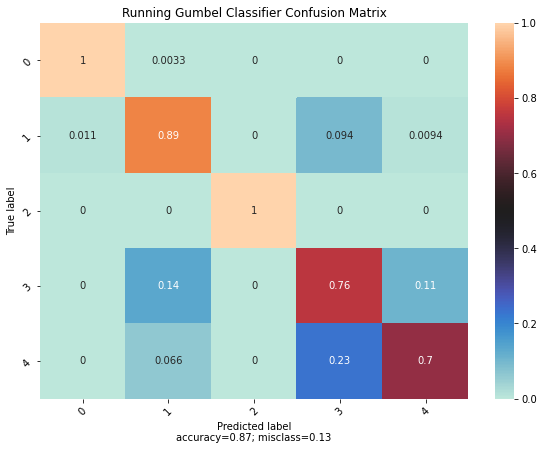

In [ ]:
results =  np.load(model_save_path + 'runningstate_classifier_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Running Gumbel Classifier Confusion Matrix', save_path = viz_save_path + 'runningstate_classifier_cm.png', cmap='icefire')

### Concrete VAE

In [ ]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.png', cmap = 'icefire')

## LassoNet

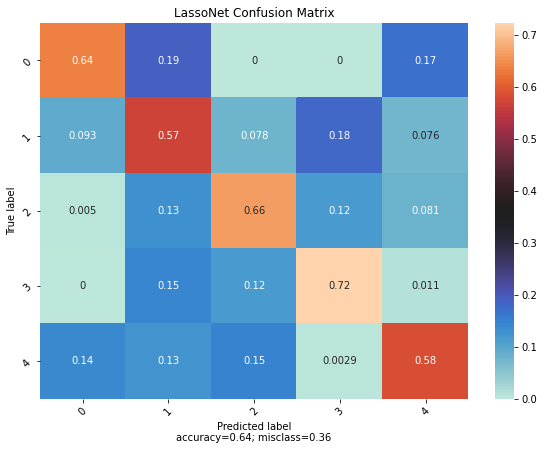

In [23]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.png', cmap = 'icefire')

## UMap Visualization

In [24]:
import cv2

In [ ]:
img = cv2.imread(viz_save_path + 'smash_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'rankcorr_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

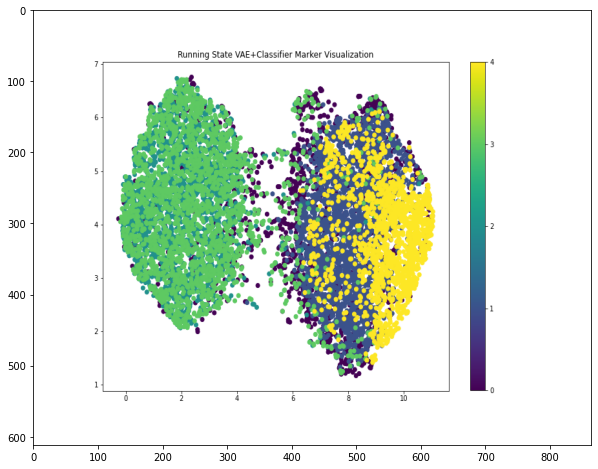

In [ ]:
img = cv2.imread(viz_save_path + 'runningstate_vae+classifier_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

In [ ]:
img = cv2.imread(viz_save_path + 'concrete_vae_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

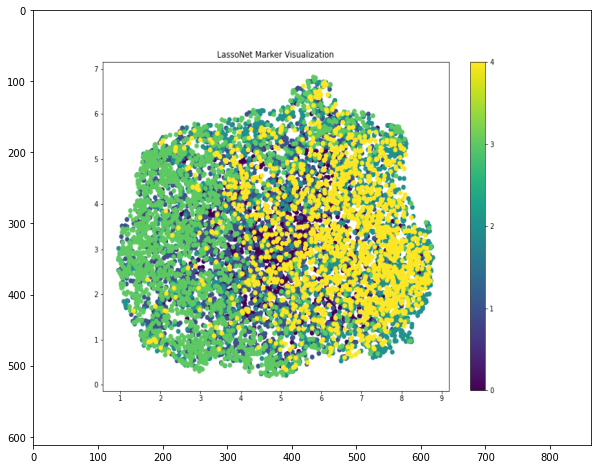

In [25]:
img = cv2.imread(viz_save_path + 'lasso_net_markers_1.png')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img[:,:, ::-1], aspect = 'auto')
plt.show()

## Visualizing Reconstructions

from first model of each

## L1 VAE

In [ ]:
model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_{}.ckpt'.format(1))
l1_vae_markers = np.load(model_save_path + 'l1_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'L1 VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_l1_vae_{}.png'.format(1), markers = l1_vae_markers)

### Global Gate VAE

In [ ]:
model = load_model(VAE_Gumbel_GlobalGate, model_save_path + 'globalgate_vae_{}.ckpt'.format(1))
globalgate_vae_markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Global Gate VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_globalgate_vae_{}.png'.format(1), markers = globalgate_vae_markers)

### Running State Gumbel VAE

In [ ]:
model = load_model(VAE_Gumbel_RunningState, model_save_path + 'runningstate_vae_{}.ckpt'.format(1))


In [ ]:
runningstate_vae_markers = np.load(model_save_path + 'runningstate_vae_markers_{}.npy'.format(1), allow_pickle=True)

In [ ]:
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]

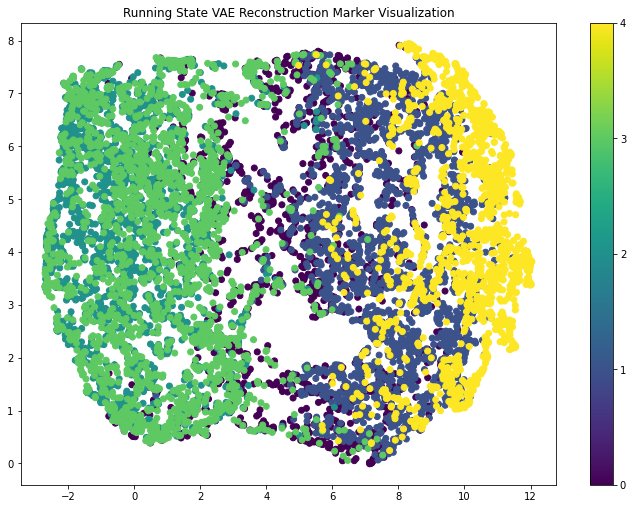

In [ ]:
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_runningstate_vae_{}.png'.format(1), markers = runningstate_vae_markers)

### RunningState VAE+Classifier

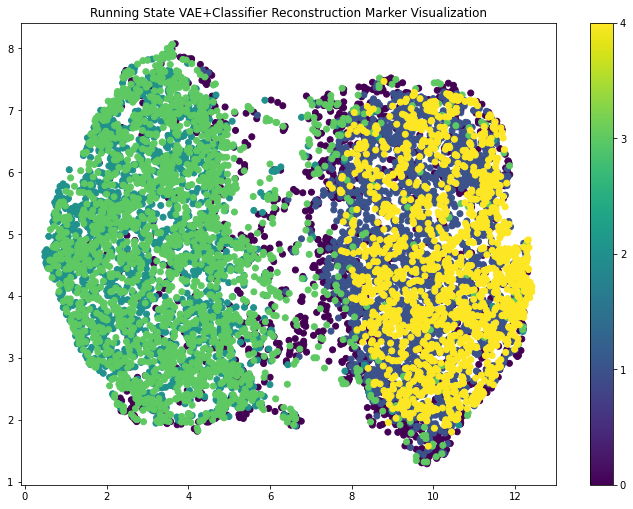

In [ ]:
model = load_model(RunningState_VAE_Classifier, model_save_path + 'runningstate_vae+classifier_{}.ckpt'.format(1))
runningstate_vae_classifier_markers = np.load(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Running State VAE+Classifier Reconstruction Marker Visualization', 
                         path = viz_save_path + 'recon_runningstate_vae+classifier_{}.png'.format(1), markers = runningstate_vae_classifier_markers)

Concrete VAE

In [ ]:
model = load_model(ConcreteVAE_NMSL, model_save_path + 'concrete_vae_{}.ckpt'.format(1))
concrete_vae_markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(1), allow_pickle=True)
with torch.no_grad():
    recon_X = model(torch.tensor(X))[0]
visualize_save_embedding(recon_X.cpu(), y, encoder, 'Concrete VAE Reconstruction Marker Visualization', path = viz_save_path + 'recon_concrete_vae_{}.png'.format(1), markers = concrete_vae_markers)

## Visualize Marker Selection

### Smash RF

In [26]:
smash_rf_markers = {}
smash_rf_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_rf_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_rf_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_rf_markers[k] = marker_data
    smash_rf_f1[k] = weighted_f1_score

### Smash DNN

In [27]:
smash_dnn_markers = {}
smash_dnn_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'smash_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'smash_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    smash_dnn_markers[k] = marker_data
    smash_dnn_f1[k] = weighted_f1_score

### RankCorr

In [28]:
rankcorr_markers ={}
rankcorr_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'rankcorr_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'rankcorr_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    rankcorr_markers[k] = marker_data
    rankcorr_f1[k] = weighted_f1_score

### L1 VAE

In [29]:
l1_vae_markers = {}
l1_vae_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(k), allow_pickle = True)
    X_train = X[train_indices, :]
    feature_std = np.apply_along_axis(np.std, 0, X_train)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'l1_vae_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']

    model = load_model(VAE_l1_diag, model_save_path + 'l1_vae_{}.ckpt'.format(k))
    with torch.no_grad():
        markers = model.markers(feature_std, 50)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    l1_vae_markers[k] = marker_data
    l1_vae_f1[k] = weighted_f1_score

### GlobalGate VAE

In [30]:
globalgate_vae_markers = {}
globalgate_vae_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'globalgate_vae_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    globalgate_vae_markers[k] = marker_data
    globalgate_vae_f1[k] = weighted_f1_score

### RunningState VAE

In [31]:
runningstate_vae_markers = {}
runningstate_vae_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/runningstate_vae_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'runningstate_vae_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'runningstate_vae_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    runningstate_vae_markers[k] = marker_data
    runningstate_vae_f1[k] = weighted_f1_score

#### RunningState Classifier

In [32]:
runningstate_classifier_markers = {}
runningstate_classifier_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/runningstate_classifier_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'runningstate_classifier_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'runningstate_classifier_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    runningstate_classifier_markers[k] = marker_data
    runningstate_classifier_f1[k] = weighted_f1_score

### RunningState VAE+Classifier

In [33]:
runningstate_vae_classifier_markers = {}
runningstate_vae_classifier_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/runningstate_vae+classifier_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'runningstate_vae+classifier_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'runningstate_vae+classifier_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    runningstate_vae_classifier_markers[k] = marker_data
    runningstate_vae_classifier_f1[k] = weighted_f1_score

In [34]:
runningstate_vae_classifier_markers

{1: array([0., 0., 0., ..., 0., 0., 0.]),
 2: array([0., 0., 0., ..., 0., 0., 0.]),
 3: array([0., 0., 0., ..., 0., 0., 0.]),
 4: array([0., 0., 0., ..., 0., 0., 0.]),
 5: array([0., 0., 0., ..., 0., 0., 0.])}

### Concrete VAE

In [35]:
concrete_vae_markers = {}
concrete_vae_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'concrete_vae_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    concrete_vae_markers[k] = marker_data
    concrete_vae_f1[k] = weighted_f1_score

## LassoNet

In [36]:
lasso_net_markers = {}
lasso_net_f1 = {}

for k in range(1,num_times+1):
    train_indices, val_indices, test_indices = np.load(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(k), allow_pickle = True)
    misclass_rate, test_rep, cm = np.load(model_save_path + 'lasso_net_results_{}.npy'.format(k), allow_pickle=True)
    weighted_f1_score = test_rep['weighted avg']['f1-score']
    markers = np.load(model_save_path + 'lasso_net_markers_{}.npy'.format(k), allow_pickle = True)
    marker_data = np.zeros(X.shape[1])
    marker_data[markers] = 1
    lasso_net_markers[k] = marker_data
    lasso_net_f1[k] = weighted_f1_score

### Actual Subplot

In [37]:
def plot_row(ax, name, num_times, markers, f1):
    k = 50
    assert len(ax) == num_times
    for i in range(1,num_times+1):
        col = ax[i-1]
        
        if i == 0:
            col.set_ylabel("{}".format(name))
        col.set_ylim([0, 1.2])
        col.set_yticks([0, 1.0])
        if np.sum(markers[i]) != 50:
            raise Exception('markers is not 50')
        col.set_title("{} Trial(Weighted F1 {:.3g})".format(i, f1[i]))        
        col.bar(range(X.shape[1]), markers[i], width = 10)
    return

In [38]:
runningstate_vae_classifier_markers

{1: array([0., 0., 0., ..., 0., 0., 0.]),
 2: array([0., 0., 0., ..., 0., 0., 0.]),
 3: array([0., 0., 0., ..., 0., 0., 0.]),
 4: array([0., 0., 0., ..., 0., 0., 0.]),
 5: array([0., 0., 0., ..., 0., 0., 0.])}

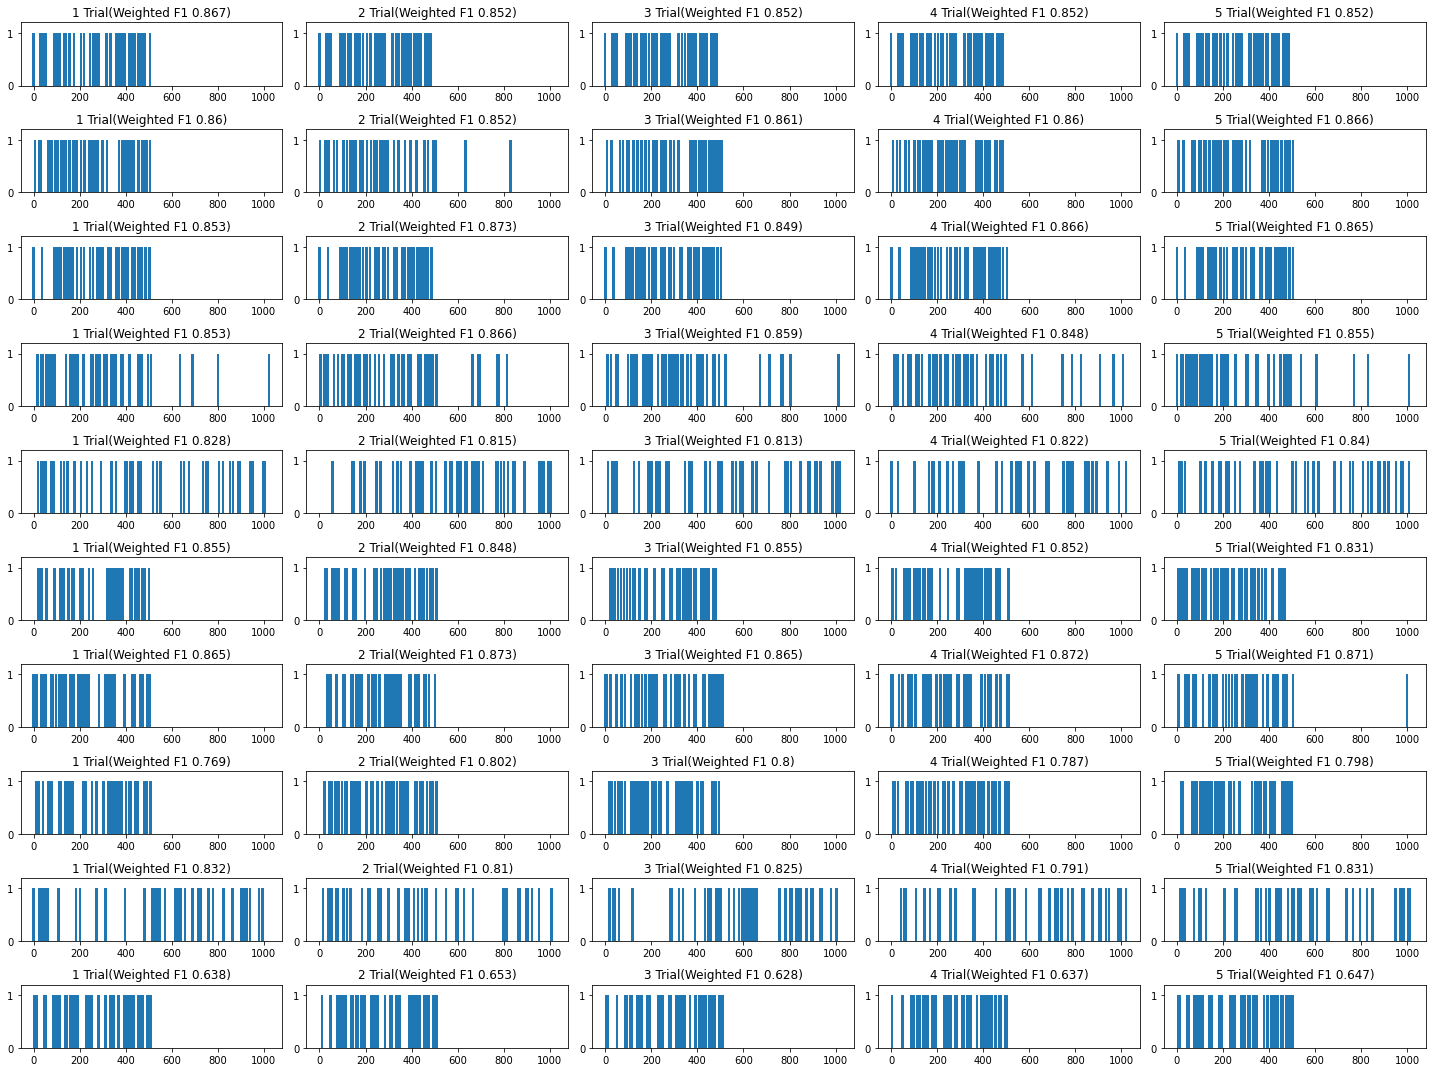

In [39]:
fig, axs = plt.subplots(nrows=10, ncols = num_times, figsize = (20, 15))

plot_row(axs[0], 'Smash RF', num_times, smash_rf_markers, smash_rf_f1)
plot_row(axs[1], 'Smash DNN', num_times, smash_dnn_markers, smash_dnn_f1)
plot_row(axs[2], 'RankCorr', num_times, rankcorr_markers, rankcorr_f1)
plot_row(axs[3], 'L1 VAE', num_times, l1_vae_markers, l1_vae_f1)
plot_row(axs[4], 'GlobalGate VAE', num_times, globalgate_vae_markers, globalgate_vae_f1)
plot_row(axs[5], 'RunningState VAE', num_times, runningstate_vae_markers, runningstate_vae_f1)
plot_row(axs[6], 'RunningState Classifier', num_times, runningstate_classifier_markers, runningstate_classifier_f1)
plot_row(axs[7], 'RunningState VAE+Classifier', num_times, runningstate_vae_classifier_markers, runningstate_vae_classifier_f1)
plot_row(axs[8], 'ConcreteVAE', num_times, concrete_vae_markers, concrete_vae_f1)
plot_row(axs[9], 'LassoNet', num_times, lasso_net_markers, lasso_net_f1)


plt.tight_layout()
plt.savefig(viz_save_path + 'SyntheticData_SelectedMarkers_All_Methods_ks.png')
plt.show()

In [40]:
plt.close('all')

# Things to note for paper

PySmash uses a seed internally so the model is deterministic to a particular dataset. We used various different train seeds, whereas the smash paper uses the whole dataset for the data.

For smash DNN, to select the markers, I had to use all the data. Couldn't just use train and val set.

The clusters are not guaranteed to be well separated in the latent space but that is fine.

Global gate vae and concrete vae are similar in performance.